# <center> Speech emotion russian

In [11]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Описание данных

In [6]:
c = 0
for prefix in os.listdir('new_data'):
    c += len(os.listdir('new_data/' + prefix))
    print(len(os.listdir('new_data/' + prefix)), ' ', prefix)
print('total', c)

37   fa
125   fc
37   fh
117   fs
37   ma
124   mc
85   mh
46   ms
total 608


Собрали выборку из `608` аудио. Всего выделено по `4` признака для каждого пола. Признак, отвечающий за испуг, был отброшен. 

## Формировние выборки

In [42]:
X, sample_rate = librosa.load('new_data/fc/1fc0.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
# twodim= np.expand_dims(livedf2, axis=2)

In [43]:
# twodim[0].reshape(1, -1)[0]

In [44]:
livedf2.columns = list(range(216))

In [52]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-42.599155,-42.599155,-38.565506,-40.79958,-40.664909,-39.178364,-39.062923,-39.181309,-41.889675,-44.287861,...,-29.585442,-31.385731,-32.928375,-32.946175,-31.390379,-31.363512,-31.420393,-33.336098,-31.142555,-28.53458


In [59]:
transformer = dict(zip(os.listdir('new_data'), list(range(8))))

In [60]:
transformer

{'fa': 0, 'fc': 1, 'fh': 2, 'fs': 3, 'ma': 4, 'mc': 5, 'mh': 6, 'ms': 7}

In [62]:
X_data = []
y_data = []
i = 0
for prefix in os.listdir('new_data'):
    for filename in os.listdir('new_data/' + prefix):
        X, sample_rate = librosa.load(f'new_data/{prefix}/{filename}', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
        featurelive = mfccs
        livedf2 = featurelive
        livedf2= pd.DataFrame(data=livedf2)
        livedf2 = livedf2.stack().to_frame().T
        X_data.append((i, livedf2.values[0]))
        y_data.append((i, transformer[prefix]))
        i += 1

In [65]:
len(X_data), len(y_data)

(608, 608)

In [69]:
X_df = pd.DataFrame(map(lambda x: x[1], X_data))

In [70]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-16.326344,-17.296888,-20.150675,-18.294147,-17.103022,-16.043945,-16.167580,-15.591326,-15.285101,-16.635576,...,-9.263520,-9.836855,-9.000297,-8.610595,-7.708127,-8.924120,-6.446887,-6.100635,-5.777068,-3.262930
1,-10.928268,-11.221898,-11.610126,-12.015554,-11.764825,-12.941557,-14.813755,-12.584860,-11.560820,-13.341023,...,-12.369427,-11.286713,-12.561003,-13.209839,-14.229598,-14.887380,-13.279887,-10.424804,-9.198820,-9.799427
2,-6.682770,-8.139627,-9.780738,-9.021040,-7.429825,-8.016786,-11.229615,-13.115143,-12.387643,-13.688749,...,2.791893,-1.644092,-7.576475,-8.142863,-3.416764,-0.235614,-0.058597,0.158079,0.453212,-1.787468
3,-5.745885,-4.851453,-2.372185,-2.677375,-1.294483,-1.588351,-3.193917,-2.840873,-1.473870,-1.941777,...,-7.527279,-8.047975,-8.805882,-10.848269,-14.466572,-14.186361,-12.370974,-11.046177,-9.836673,-6.553540
4,-11.175696,-9.916759,-10.240388,-9.676003,-9.011184,-8.094333,-8.224344,-6.904289,-6.189703,-6.950838,...,-8.104716,-6.638175,-5.050791,-5.673285,-6.665066,-7.014104,-7.494484,-9.089967,-6.788941,0.912188


In [71]:
y_df = pd.DataFrame(map(lambda x: x[1], y_data))

In [72]:
y_df.head()

,0
0,0
1,0
2,0
3,0
4,0


## OneHotEncoding

In [80]:
y_df_one_hot = pd.get_dummies(y_df[0])

In [94]:
y_df_one_hot.columns = ['y' + str(i) for i in range(8)]

In [95]:
y_df_one_hot.head()

,y0,y1,y2,y3,y4,y5,y6,y7
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


## Train Test

In [98]:
data = pd.concat([X_df, y_df_one_hot], axis=1, join="inner")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,y0,y1,y2,y3,y4,y5,y6,y7
0,-16.326344,-17.296888,-20.150675,-18.294147,-17.103022,-16.043945,-16.167580,-15.591326,-15.285101,-16.635576,...,-5.777068,-3.262930,1,0,0,0,0,0,0,0
1,-10.928268,-11.221898,-11.610126,-12.015554,-11.764825,-12.941557,-14.813755,-12.584860,-11.560820,-13.341023,...,-9.198820,-9.799427,1,0,0,0,0,0,0,0
2,-6.682770,-8.139627,-9.780738,-9.021040,-7.429825,-8.016786,-11.229615,-13.115143,-12.387643,-13.688749,...,0.453212,-1.787468,1,0,0,0,0,0,0,0
3,-5.745885,-4.851453,-2.372185,-2.677375,-1.294483,-1.588351,-3.193917,-2.840873,-1.473870,-1.941777,...,-9.836673,-6.553540,1,0,0,0,0,0,0,0
4,-11.175696,-9.916759,-10.240388,-9.676003,-9.011184,-8.094333,-8.224344,-6.904289,-6.189703,-6.950838,...,-6.788941,0.912188,1,0,0,0,0,0,0,0


Перемешиваем строки

In [100]:
data = data.sample(frac=1)

In [101]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,y0,y1,y2,y3,y4,y5,y6,y7
212,-14.336365,-18.434166,-36.444893,-38.979946,-40.082039,-40.134129,-39.824482,-39.696331,-39.672905,-39.855225,...,-34.288723,-32.329247,0,0,0,1,0,0,0,0
435,-26.844685,-26.372921,-25.670422,-26.496016,-28.097734,-28.804609,-30.319942,-28.326519,-27.521799,-27.171021,...,-25.452099,-23.930685,0,0,0,0,0,1,0,0
87,-21.369804,-24.315451,-31.552065,-33.512909,-34.008701,-34.261051,-34.469383,-37.682602,-38.426376,-40.362045,...,-34.003563,-40.224724,0,1,0,0,0,0,0,0
186,2.831125,-0.877010,-12.888726,-12.064869,-8.980460,-10.204863,-8.665296,-7.667361,-9.432409,-11.393543,...,-2.723922,3.454707,0,0,1,0,0,0,0,0
494,-22.577364,-20.864346,-18.304888,-18.314985,-18.753752,-15.360708,-11.249742,-10.554243,-10.458380,-9.313645,...,-20.980644,-25.071024,0,0,0,0,0,0,1,0


In [104]:
Train_data = data[:500]
Test_data = data[500:]

In [128]:
X_train = Train_data[list(range(216))]
X_test = Test_data[list(range(216))]
X_train.shape, X_test.shape

((500, 216), (108, 216))

In [129]:
X_train = X_train.values.reshape(500, 216, 1)
X_test = X_test.values.reshape(108, 216, 1)
X_train.shape, X_test.shape

((500, 216, 1), (108, 216, 1))

In [116]:
y_train = Train_data[y_df_one_hot.columns]
y_test = Test_data[y_df_one_hot.columns]

## Модель

In [131]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [132]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_24 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_25 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 27, 128)          

In [133]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [134]:
cnnhistory=model.fit(X_train, y_train, batch_size=16, epochs=700, validation_data=(X_test, y_test))

Epoch 1/700
32/32 [==============================] - 4s 66ms/step - loss: 2.1104 - accuracy: 0.1353 - val_loss: 1.8318 - val_accuracy: 0.1389
Epoch 2/700
32/32 [==============================] - 2s 50ms/step - loss: 1.7799 - accuracy: 0.2112 - val_loss: 1.7638 - val_accuracy: 0.1389
Epoch 3/700
32/32 [==============================] - 2s 51ms/step - loss: 1.7474 - accuracy: 0.1965 - val_loss: 1.7341 - val_accuracy: 0.1667
Epoch 4/700
32/32 [==============================] - 2s 51ms/step - loss: 1.6838 - accuracy: 0.2355 - val_loss: 1.7378 - val_accuracy: 0.1389
Epoch 5/700
32/32 [==============================] - 1s 42ms/step - loss: 1.6803 - accuracy: 0.2197 - val_loss: 1.7039 - val_accuracy: 0.2037
Epoch 6/700
32/32 [==============================] - 1s 46ms/step - loss: 1.7123 - accuracy: 0.1918 - val_loss: 1.6894 - val_accuracy: 0.2685
Epoch 7/700
32/32 [==============================] - 1s 44ms/step - loss: 1.6956 - accuracy: 0.1851 - val_loss: 1.6959 - val_accuracy: 0.1574
Epoch 

32/32 [==============================] - 1s 43ms/step - loss: 0.8514 - accuracy: 0.6415 - val_loss: 0.9298 - val_accuracy: 0.5833
Epoch 59/700
32/32 [==============================] - 1s 44ms/step - loss: 0.8881 - accuracy: 0.6458 - val_loss: 0.9657 - val_accuracy: 0.5370
Epoch 60/700
32/32 [==============================] - 1s 42ms/step - loss: 0.9047 - accuracy: 0.6299 - val_loss: 0.8924 - val_accuracy: 0.6111
Epoch 61/700
32/32 [==============================] - 1s 42ms/step - loss: 0.8384 - accuracy: 0.6699 - val_loss: 0.9287 - val_accuracy: 0.6019
Epoch 62/700
32/32 [==============================] - 1s 44ms/step - loss: 0.8096 - accuracy: 0.6764 - val_loss: 0.8986 - val_accuracy: 0.6204
Epoch 63/700
32/32 [==============================] - 1s 44ms/step - loss: 0.8064 - accuracy: 0.7106 - val_loss: 0.8551 - val_accuracy: 0.6852
Epoch 64/700
32/32 [==============================] - 1s 43ms/step - loss: 0.8429 - accuracy: 0.6691 - val_loss: 0.9031 - val_accuracy: 0.5926
Epoch 65/700

32/32 [==============================] - 1s 41ms/step - loss: 0.6069 - accuracy: 0.7674 - val_loss: 0.7602 - val_accuracy: 0.6944
Epoch 116/700
32/32 [==============================] - 1s 41ms/step - loss: 0.6022 - accuracy: 0.7530 - val_loss: 0.9289 - val_accuracy: 0.5741
Epoch 117/700
32/32 [==============================] - 1s 42ms/step - loss: 0.5646 - accuracy: 0.8024 - val_loss: 0.9453 - val_accuracy: 0.5833
Epoch 118/700
32/32 [==============================] - 1s 42ms/step - loss: 0.6028 - accuracy: 0.7550 - val_loss: 0.7380 - val_accuracy: 0.6759
Epoch 119/700
32/32 [==============================] - 1s 46ms/step - loss: 0.5684 - accuracy: 0.7773 - val_loss: 0.7419 - val_accuracy: 0.6759
Epoch 120/700
32/32 [==============================] - 1s 43ms/step - loss: 0.5940 - accuracy: 0.7918 - val_loss: 0.7516 - val_accuracy: 0.7037
Epoch 121/700
32/32 [==============================] - 1s 42ms/step - loss: 0.5690 - accuracy: 0.7943 - val_loss: 0.8491 - val_accuracy: 0.6296
Epoch 

Epoch 172/700
32/32 [==============================] - 1s 40ms/step - loss: 0.4125 - accuracy: 0.8436 - val_loss: 0.6747 - val_accuracy: 0.7407
Epoch 173/700
32/32 [==============================] - 1s 40ms/step - loss: 0.4082 - accuracy: 0.8699 - val_loss: 0.6772 - val_accuracy: 0.7315
Epoch 174/700
32/32 [==============================] - 1s 40ms/step - loss: 0.4341 - accuracy: 0.8380 - val_loss: 0.7222 - val_accuracy: 0.7130
Epoch 175/700
32/32 [==============================] - 1s 40ms/step - loss: 0.4368 - accuracy: 0.8271 - val_loss: 0.8316 - val_accuracy: 0.6852
Epoch 176/700
32/32 [==============================] - 1s 40ms/step - loss: 0.4352 - accuracy: 0.8553 - val_loss: 0.7619 - val_accuracy: 0.7037
Epoch 177/700
32/32 [==============================] - 1s 40ms/step - loss: 0.3637 - accuracy: 0.9038 - val_loss: 0.8285 - val_accuracy: 0.6944
Epoch 178/700
32/32 [==============================] - 1s 40ms/step - loss: 0.3977 - accuracy: 0.8674 - val_loss: 0.7236 - val_accuracy:

32/32 [==============================] - 1s 44ms/step - loss: 0.3028 - accuracy: 0.9176 - val_loss: 0.6762 - val_accuracy: 0.7407
Epoch 229/700
32/32 [==============================] - 1s 43ms/step - loss: 0.3091 - accuracy: 0.8924 - val_loss: 0.8131 - val_accuracy: 0.7315
Epoch 230/700
32/32 [==============================] - 1s 43ms/step - loss: 0.2777 - accuracy: 0.9184 - val_loss: 0.7447 - val_accuracy: 0.7500
Epoch 231/700
32/32 [==============================] - 1s 42ms/step - loss: 0.3128 - accuracy: 0.8963 - val_loss: 0.8681 - val_accuracy: 0.6944
Epoch 232/700
32/32 [==============================] - 1s 43ms/step - loss: 0.3196 - accuracy: 0.8762 - val_loss: 0.6909 - val_accuracy: 0.7593
Epoch 233/700
32/32 [==============================] - 1s 42ms/step - loss: 0.2822 - accuracy: 0.9164 - val_loss: 0.6335 - val_accuracy: 0.7685
Epoch 234/700
32/32 [==============================] - 2s 48ms/step - loss: 0.2898 - accuracy: 0.9051 - val_loss: 0.6158 - val_accuracy: 0.7870
Epoch 

Epoch 285/700
32/32 [==============================] - 1s 47ms/step - loss: 0.2106 - accuracy: 0.9264 - val_loss: 0.7164 - val_accuracy: 0.7685
Epoch 286/700
32/32 [==============================] - 2s 50ms/step - loss: 0.2024 - accuracy: 0.9301 - val_loss: 0.6344 - val_accuracy: 0.7963
Epoch 287/700
32/32 [==============================] - 1s 44ms/step - loss: 0.2401 - accuracy: 0.9203 - val_loss: 0.7103 - val_accuracy: 0.7870
Epoch 288/700
32/32 [==============================] - 1s 43ms/step - loss: 0.2107 - accuracy: 0.9374 - val_loss: 0.7315 - val_accuracy: 0.7778
Epoch 289/700
32/32 [==============================] - 1s 45ms/step - loss: 0.2380 - accuracy: 0.9185 - val_loss: 0.8487 - val_accuracy: 0.7222
Epoch 290/700
32/32 [==============================] - 1s 43ms/step - loss: 0.2061 - accuracy: 0.9247 - val_loss: 0.6450 - val_accuracy: 0.7685
Epoch 291/700
32/32 [==============================] - 1s 45ms/step - loss: 0.2089 - accuracy: 0.9230 - val_loss: 0.6535 - val_accuracy:

32/32 [==============================] - 1s 40ms/step - loss: 0.1474 - accuracy: 0.9687 - val_loss: 0.6496 - val_accuracy: 0.7963
Epoch 342/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1310 - accuracy: 0.9629 - val_loss: 0.6479 - val_accuracy: 0.8333
Epoch 343/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1763 - accuracy: 0.9527 - val_loss: 0.6393 - val_accuracy: 0.8241
Epoch 344/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1261 - accuracy: 0.9759 - val_loss: 0.6156 - val_accuracy: 0.8241
Epoch 345/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1624 - accuracy: 0.9511 - val_loss: 0.6396 - val_accuracy: 0.8241
Epoch 346/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1161 - accuracy: 0.9733 - val_loss: 0.6364 - val_accuracy: 0.7963
Epoch 347/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1622 - accuracy: 0.9683 - val_loss: 0.7986 - val_accuracy: 0.7778
Epoch 

Epoch 398/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1113 - accuracy: 0.9749 - val_loss: 0.7008 - val_accuracy: 0.8333
Epoch 399/700
32/32 [==============================] - 1s 40ms/step - loss: 0.1012 - accuracy: 0.9646 - val_loss: 0.6561 - val_accuracy: 0.8333
Epoch 400/700
32/32 [==============================] - 1s 40ms/step - loss: 0.0944 - accuracy: 0.9739 - val_loss: 0.6868 - val_accuracy: 0.8426
Epoch 401/700
32/32 [==============================] - 1s 42ms/step - loss: 0.1021 - accuracy: 0.9739 - val_loss: 0.7612 - val_accuracy: 0.8056
Epoch 402/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0930 - accuracy: 0.9730 - val_loss: 0.7074 - val_accuracy: 0.8056
Epoch 403/700
32/32 [==============================] - 1s 41ms/step - loss: 0.1060 - accuracy: 0.9740 - val_loss: 0.6990 - val_accuracy: 0.7963
Epoch 404/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0729 - accuracy: 0.9854 - val_loss: 0.7007 - val_accuracy:

Epoch 455/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0724 - accuracy: 0.9854 - val_loss: 0.7159 - val_accuracy: 0.8333
Epoch 456/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0657 - accuracy: 0.9814 - val_loss: 0.7974 - val_accuracy: 0.8056
Epoch 457/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0646 - accuracy: 0.9848 - val_loss: 0.8950 - val_accuracy: 0.7685
Epoch 458/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0609 - accuracy: 0.9920 - val_loss: 0.8605 - val_accuracy: 0.7593
Epoch 459/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0789 - accuracy: 0.9827 - val_loss: 0.7681 - val_accuracy: 0.8056
Epoch 460/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0882 - accuracy: 0.9763 - val_loss: 0.8530 - val_accuracy: 0.8056
Epoch 461/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0550 - accuracy: 0.9865 - val_loss: 0.8308 - val_accuracy:

Epoch 512/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0626 - accuracy: 0.9877 - val_loss: 0.9998 - val_accuracy: 0.7685
Epoch 513/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0384 - accuracy: 0.9970 - val_loss: 0.8389 - val_accuracy: 0.7870
Epoch 514/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0488 - accuracy: 0.9861 - val_loss: 0.8798 - val_accuracy: 0.8056
Epoch 515/700
32/32 [==============================] - 1s 40ms/step - loss: 0.0744 - accuracy: 0.9802 - val_loss: 0.8391 - val_accuracy: 0.8333
Epoch 516/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0355 - accuracy: 0.9917 - val_loss: 0.7737 - val_accuracy: 0.8333
Epoch 517/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0436 - accuracy: 0.9909 - val_loss: 0.8469 - val_accuracy: 0.8333
Epoch 518/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0464 - accuracy: 0.9905 - val_loss: 0.8357 - val_accuracy:

Epoch 569/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0299 - accuracy: 0.9975 - val_loss: 1.0557 - val_accuracy: 0.7870
Epoch 570/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0413 - accuracy: 0.9845 - val_loss: 0.9159 - val_accuracy: 0.8056
Epoch 571/700
32/32 [==============================] - 1s 40ms/step - loss: 0.0441 - accuracy: 0.9944 - val_loss: 0.9649 - val_accuracy: 0.8148
Epoch 572/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0259 - accuracy: 0.9973 - val_loss: 0.8570 - val_accuracy: 0.8333
Epoch 573/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0318 - accuracy: 0.9976 - val_loss: 0.9276 - val_accuracy: 0.8056
Epoch 574/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0341 - accuracy: 0.9882 - val_loss: 0.8937 - val_accuracy: 0.8333
Epoch 575/700
32/32 [==============================] - 1s 43ms/step - loss: 0.0217 - accuracy: 0.9996 - val_loss: 1.0219 - val_accuracy:

Epoch 626/700
32/32 [==============================] - 1s 43ms/step - loss: 0.0162 - accuracy: 0.9976 - val_loss: 0.9626 - val_accuracy: 0.8241
Epoch 627/700
32/32 [==============================] - 1s 43ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.0038 - val_accuracy: 0.7870
Epoch 628/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0493 - accuracy: 0.9907 - val_loss: 0.9294 - val_accuracy: 0.8333
Epoch 629/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0203 - accuracy: 0.9947 - val_loss: 0.9544 - val_accuracy: 0.8241
Epoch 630/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.9268 - val_accuracy: 0.8056
Epoch 631/700
32/32 [==============================] - 1s 39ms/step - loss: 0.0179 - accuracy: 0.9974 - val_loss: 1.1940 - val_accuracy: 0.8056
Epoch 632/700
32/32 [==============================] - 1s 39ms/step - loss: 0.0560 - accuracy: 0.9899 - val_loss: 0.9509 - val_accuracy:

Epoch 683/700
32/32 [==============================] - 1s 43ms/step - loss: 0.0195 - accuracy: 0.9975 - val_loss: 0.9978 - val_accuracy: 0.8148
Epoch 684/700
32/32 [==============================] - 1s 40ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 1.0845 - val_accuracy: 0.8056
Epoch 685/700
32/32 [==============================] - 1s 40ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 1.0603 - val_accuracy: 0.8241
Epoch 686/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0130 - accuracy: 0.9988 - val_loss: 1.1127 - val_accuracy: 0.8241
Epoch 687/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0120 - accuracy: 0.9978 - val_loss: 0.9948 - val_accuracy: 0.8426
Epoch 688/700
32/32 [==============================] - 1s 41ms/step - loss: 0.0171 - accuracy: 0.9969 - val_loss: 1.0002 - val_accuracy: 0.8333
Epoch 689/700
32/32 [==============================] - 1s 42ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.0338 - val_accuracy:

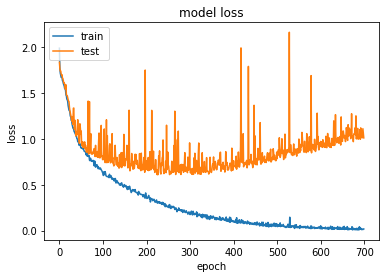

In [135]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

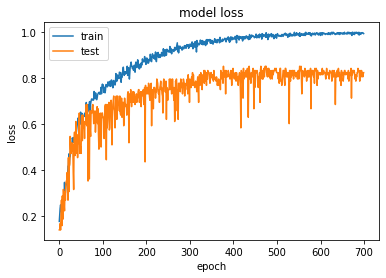

In [136]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Видим повторение картины, которая наблюдается в статье. Качество модели на тестовой выборке около `70-80%`. Это хороший результат, но скорее всего некорректный. 

В данной работе, как и в статье, качество на валидации оценивалось на голосах спикеров, которые присутствуют в обучающей выборке. Следует проверить качество модели на новых голосах.

## Проверка на новых голосах

Сохраним модель.

In [137]:
model_name = 'Emotion_Voice_Detection_Model_Russian.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\79217\Documents\Personal_assistent\speech_emotion\Speech-Emotion-Analyzer\saved_models\Emotion_Voice_Detection_Model_Russian.h5 


In [138]:
import json
model_json = model.to_json()
with open("model_russian.json", "w") as json_file:
    json_file.write(model_json)

Загрузим модель

In [143]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model_russian.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model_Russian.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


In [164]:
X, sample_rate = librosa.load('my_data/from_public/2_ms.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [165]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
twodim= np.expand_dims(livedf2, axis=2)
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)
livepreds1=livepreds.argmax(axis=1)

1/1 [==============================] - 0s 13ms/step


In [166]:
livepreds1

array([6], dtype=int64)

In [167]:
transformer

{'fa': 0, 'fc': 1, 'fh': 2, 'fs': 3, 'ma': 4, 'mc': 5, 'mh': 6, 'ms': 7}

На новых голосах модель работает просто ужасно. В качестве новых голосов были выбраны живые голосовые сообщения. 

## To do

1. Использовать другие голоса на валидации.

2. Возможно, поменять модель. 

Эту модель пока нельзя использовать для разметки.